In [1]:
import sys
sys.path.append("/opt/ml/level2_objectdetection-cv-09")
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageDraw, ImageFont
import json
import os
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from collections import defaultdict
from dataloader.dataset import CustomDataset ,split_train_valid, get_all_annotation, get_json_data

In [2]:
with open('/opt/ml/dataset/train.json') as f:
    json_data = json.load(f)
print(json_data.keys())
print(json_data['info'])
print(len(json_data['annotations']))
print(json_data['annotations'][1])
print(json_data['images'][1])

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])
{'year': 2021, 'version': '1.0', 'description': 'Recycle Trash', 'contributor': 'Upstage', 'url': None, 'date_created': '2021-02-02 01:10:00'}
23144
{'image_id': 1, 'category_id': 3, 'area': 10402.56, 'bbox': [0.0, 407.4, 57.6, 180.6], 'iscrowd': 0, 'id': 1}
{'width': 1024, 'height': 1024, 'file_name': 'train/0001.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2021-01-10 16:30:39', 'id': 1}


In [3]:
data_root_dir = '/opt/ml/dataset'
json_data = get_json_data(data_root_dir)
    
json_anno = get_all_annotation(json_data)

train_info, val_info = split_train_valid(data_root_dir, json_data)

print(train_info[3])
print(json_anno[train_info[3][0]])
data_transform = {
        "train": A.Compose([
            A.HorizontalFlip(p=1),
            A.RandomBrightnessContrast(p=0.2),
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['labels'])),
        "val": A.Compose([
            ToTensorV2(),
            ], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['labels']))
    }


dataset = CustomDataset(train_info, json_anno,data_transform['train'])


['4129' '/opt/ml/dataset/train/4129.jpg']
[{'image_id': 4129, 'category_id': 1, 'area': 457000.8, 'bbox': [251.6, 175.5, 586.5, 779.2], 'iscrowd': 0, 'id': 19553}]


In [4]:
img,d = dataset.__getitem__(3)
d

{'boxes': tensor([[186.9000, 175.5000, 772.4000, 953.7000]]),
 'labels': tensor([2], dtype=torch.int32),
 'image_id': tensor([3]),
 'area': tensor([455636.0938]),
 'iscrowd': tensor([0], dtype=torch.int32)}

In [5]:
type(img)

torch.Tensor

img shape torch.Size([3, 1024, 1024])
['background', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']


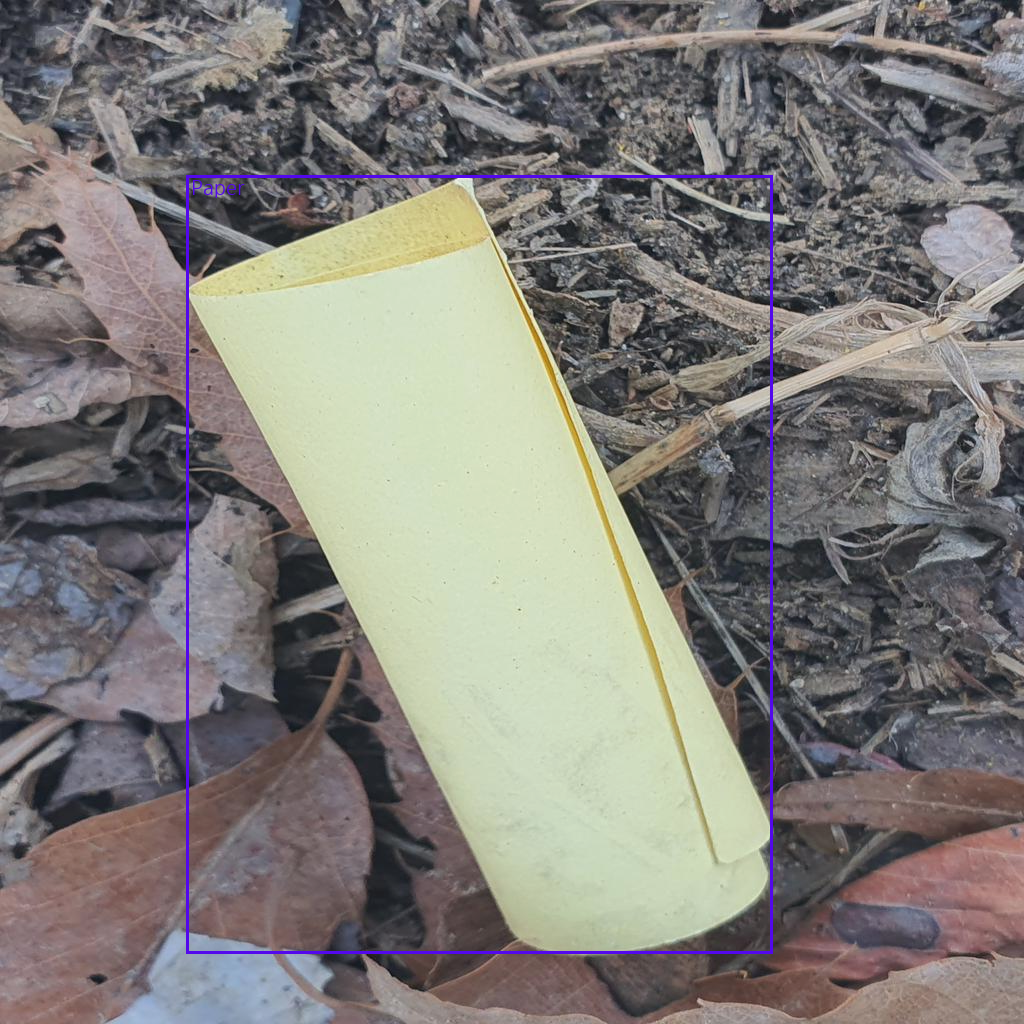

In [6]:
import random
print(f"img shape {img.shape}")
img = (img*255).permute(1,2,0).numpy().astype(np.uint8)
img = Image.fromarray(img)
boxes = d['boxes'].numpy()
labels = d['labels'].numpy()
classes = dataset.classes
print(classes)
colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(len(classes))]
draw = ImageDraw.Draw(img)
for i in range(len(boxes)):
    box = boxes[i]
    label = labels[i]
    color = colors[label]
    font = ImageFont.truetype('/usr/share/fonts/truetype/nanum/NanumGothic.ttf',20)
    draw.rectangle(box, outline=color, width=3)
    draw.text((box[0]+5,box[1]),  classes[label], font=font, fill=color)
img.show()

In [7]:
train_data_loader = torch.utils.data.DataLoader(dataset,
                                                    batch_size=4,
                                                    shuffle=True,
                                                    num_workers=0,
                                                    collate_fn=dataset.collate_fn)

In [8]:
images,targets = next(iter(train_data_loader))
images = np.array(image.item() for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]